In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, parallel_backend
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
from sklearn.metrics import roc_curve, auc


In [2]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def clean_text(text):
    stop = stopwords.words('english')       
    punc = list(punctuation)
    bad_tokens = stop + punc
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in bad_tokens]
    return " ".join(clean_token)

def evaluate_roc_probs(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def apply_cleaning(X_train):
    '''
    With this fonction we apply the clean_text function to the text column of the data
    and it gives as output the cleaned data for each row of the text column
    '''
    X_train = X_train.apply(lambda x: clean_text(x))
    return(X_train)

def tfidf_featured_data(X_train):
    ''''
    No need to explain this function because we gonna use it in the pipeline automatically this function
    used to add tf-idfs columns to the data but I used this to play around with the data and see the
    results of the tfidf vectorizer
    '''

    X_train = apply_cleaning(X_train)
    # add tf-idfs columns
    tfidf = TfidfVectorizer(min_df = 30)
    tfidf_result = tfidf.fit_transform(X_train).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = X_train.index
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns = ['sentences'], inplace = True)
    
    return X_train

def dict2text(dicti):
    '''
    This function is used to convert the dictionary of parameters to a string
    used for GridsearchCV outputs to be saved in a csv file and to be used later 
    on project.
    '''
    text = ''
    for key, value in dicti.items():
        text += str(key) + '=' + str(value) + ' '
    return text

def format_params(params_str):
    '''
    I captured some differences between the parameters of the GridsearchCV output
    to standardize it and make it easy to be used later on the project.
    '''
    # Remove the opening and closing braces and quotes
    params_str = params_str.replace("{", "").replace("}", "").replace("'", "")

    # Replace commas with spaces
    params_str = params_str.replace(", ", " ")

    # Replace colons with equals signs
    params_str = params_str.replace(":", "=")

    # Remove spaces around equals signs
    params_str = params_str.replace("= ", "=").replace(" =", "=")

    return params_str

def evaluate_roc(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def roc_auc(test, y_pred):
    # Assuming y_true contains the true labels (0 or 1) and y_pred contains the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(test.values, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

<AxesSubplot:xlabel='sentiment'>

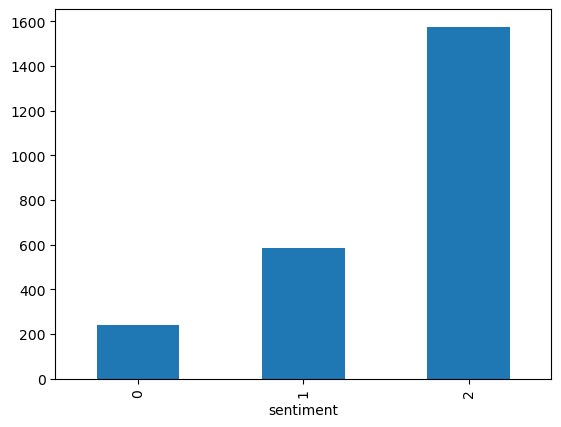

In [3]:
train = pd.read_csv('train.csv')
train["sentiment"].groupby(train["sentiment"]).count().plot(kind="bar")

In [4]:
slices = [train[:2404]]

# Define the pipeline with normalization
pipeline_without_norm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

# Define the hyperparameters to tune for each pipeline
parameters_without_norm = {
    'tfidf__max_features': [1000],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf']
}

dfs = []
z=0
for i, slice in enumerate(slices):
    print("Slice: ", i+1, str(len(slice)))
    
    # Create a GridSearchCV object for each pipeline
    grid_search_without_norm = GridSearchCV(pipeline_without_norm, parameters_without_norm, cv=3, verbose=3)

    with parallel_backend(backend="multiprocessing", n_jobs=-1):
        # Fit the GridSearchCV object on the training data
        grid_search_without_norm.fit(slice["text"], slice["sentiment"])

    # Print the accuracy score and best hyperparameters for the current slice
    print("Best hyperparameters: ", grid_search_without_norm.best_params_)
    print("Best accuracy score: ", grid_search_without_norm.best_score_)
    z+=1
    #store it in a dataframe
    df = pd.DataFrame(list(zip(grid_search_without_norm.cv_results_['params'], grid_search_without_norm.cv_results_['mean_test_score'])), columns=['params', 'mean_test_score of batch '+str(i)])
    df.to_csv('grid_search_results1_batch'+str(i)+'.csv')
    dfs.append(df)
if z>1:
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    dfs["params"] = dfs["params"].apply(lambda x: dict2text(x))
    dfs = dfs.groupby(['params']).mean().to_csv('grid_search_results.csv')


Slice:  1 2404
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best hyperparameters:  {'svc__C': 10, 'svc__kernel': 'rbf', 'tfidf__max_features': 1000}
Best accuracy score:  0.7333632211605817


In [5]:
train = pd.read_csv("train.csv")
train["text"] = apply_cleaning(train["text"])
test = pd.read_csv(("test.csv"))
test["text"] = apply_cleaning(test["text"])

In [6]:
from sklearn.calibration import CalibratedClassifierCV

# Train the model with best hyperparameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svc', LinearSVC(dual=False, penalty='l2', loss='squared_hinge', C=0.1)),
])

pipeline.fit(train["text"], train["sentiment"])

# Vectorize the training data
X_train = pipeline.named_steps['tfidf'].transform(train["text"])

# Train the model with best hyperparameters
calibrated_model = CalibratedClassifierCV(pipeline.named_steps['svc'])
calibrated_model.fit(X_train, train["sentiment"])

X_test = pipeline.named_steps['tfidf'].transform(test["text"])
# Predict probabilities for the test data
y_pred_proba = calibrated_model.predict_proba(X_test)

# Obtain the predicted class labels
y_pred = calibrated_model.predict(X_test)


[LibLinear]Classification Report
              precision    recall  f1-score   support

           0       0.88      0.13      0.22       117
           1       0.70      0.22      0.33       302
           2       0.70      0.98      0.82       784

    accuracy                           0.70      1203
   macro avg       0.76      0.44      0.46      1203
weighted avg       0.72      0.70      0.64      1203



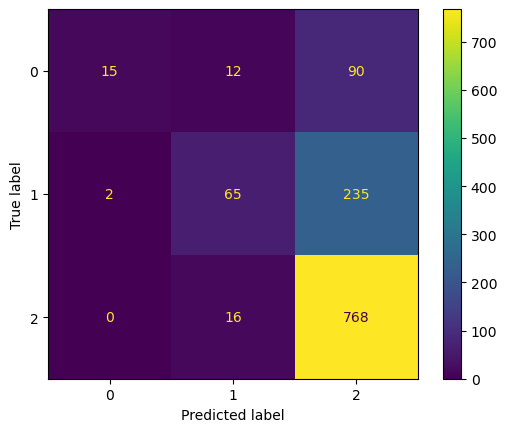

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC

# Define and train the pipeline with best hyperparameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svc', LinearSVC(dual=False, penalty='l2', loss='squared_hinge', C=0.1, verbose=3)),
])

pipeline.fit(train["text"], train["sentiment"])
pd.DataFrame(y_pred).to_csv('y_pred_proba_tf-idfsvm.csv')

# Make predictions on the test set
y_pred = pipeline.predict(test["text"])
pd.DataFrame(y_pred).to_csv("y_pred_tf-idfsvm.csv")

y_test = test["sentiment"]

# Evaluate the model
def evaluation_parametrics(name, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    t1 = ConfusionMatrixDisplay(cm)
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    t1.plot()

evaluation_parametrics("Machine Learning Classification", y_test, y_pred)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

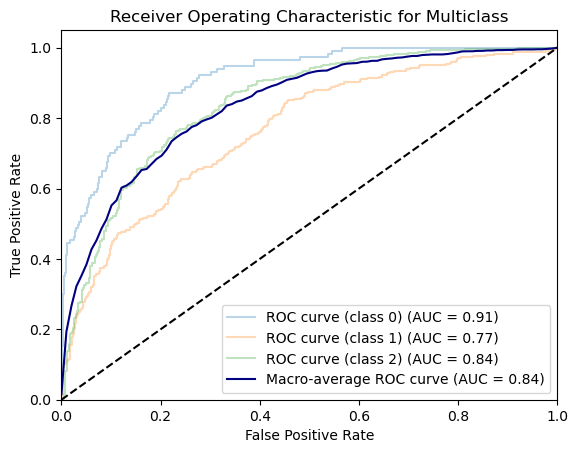

In [10]:
# Compute decision scores for each class
decision_scores = pipeline.decision_function(test["text"])

# The sigmoid function - converts decision scores into probabilities
# Since SVM doesn't natively provide probabilities, we need to calibrate the scores
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import label_binarize


calibrated_classifier = CalibratedClassifierCV(pipeline, method='sigmoid')
calibrated_classifier.fit(train["text"], train["sentiment"])

# Compute predicted probabilities using the calibrated classifier
y_pred_probs = calibrated_classifier.predict_proba(test["text"])




def evaluate_roc_probs(probs, y_true, average='micro'):

    n_classes = probs.shape[1]

    # Binarize the labels
    y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))

    # Compute ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro/macro-averaged ROC curve and ROC area
    if average == 'micro':
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr_macro = all_fpr
        tpr_macro = mean_tpr
        roc_auc_macro = auc(fpr_macro, tpr_macro)

        plt.plot(fpr_macro, tpr_macro, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc_macro))
    
    elif average == 'macro':
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]), alpha=0.3)
        
        # Compute macro-average ROC curve and ROC area
        fpr_macro = np.linspace(0, 1, 100)
        tpr_macro = np.zeros_like(fpr_macro)
        for i in range(n_classes):
            tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
        tpr_macro /= n_classes
        roc_auc_macro = auc(fpr_macro, tpr_macro)
        
        plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = {:.2f})'.format(roc_auc_macro), color='navy')
    
    else:
        raise ValueError("Invalid value for 'average'. Use 'micro' or 'macro'.")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multiclass')
    plt.legend(loc="lower right")
    plt.show()

evaluate_roc_probs(y_pred_probs, test["sentiment"].values, average='macro')

In [11]:
# Generate predictions using your model and add them to the DataFrame
test['y_pred'] = pipeline.predict(test["text"])
# Filter test set where model failed to predict the label correctly
failed_predictions = test[test["sentiment"] != test["y_pred"]]
# Sample 5 random observations from the filtered set
random_failed_samples = failed_predictions.sample(5, random_state=42)
print(random_failed_samples)


                                                   text  sentiment  y_pred
221   Loved other Tatcha products for their exfoliat...          0       1
809   Recommended to me by a friend, but it just sim...          0       2
725   This serum is so nice! Feels really lightweigh...          1       2
154   I got this and was excited to try it, but the ...          1       2
1188  I am a specialist in skin, and I have used it ...          0       1


<AxesSubplot:xlabel='sentiment'>

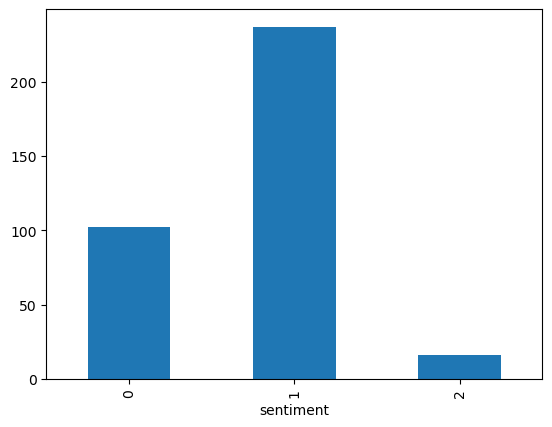

In [12]:
test = pd.read_csv(("test.csv"))
test["y_pred"] = y_pred
test[test["sentiment"] != test["y_pred"]].groupby('sentiment').count()["text"].plot(kind="bar")

In [13]:
pd.set_option('display.max_colwidth', None)
test[test["sentiment"] != test["y_pred"]].sample(5)

,text,sentiment,y_pred
1102,Great product but leaves a sticky finish at first but disolves eventually,1,2
311,Ordered this online because of all of the amazing reviews but dear God the smell is repulsive. Wish I could’ve given it a chance but had to wash it off immediately to not throw up,0,2
664,I received this product complimentary from #topbox and Clinique the sample size was small but from what I used the product is nice and would like to buy again,1,2
615,"I bought this product for my pimples after developing quite the acne spot from constant use of masks and especially the humidity and sweatiness while wearing them in the summer. I would best describe my skin as: quite sensitive, oily on the T-zone (especially my nose), normal every where else, pimple prone on the outer cheeks and a bit every where else, has discolouration, around mouth and chin, doesn’t tolerate a lot of product and a lot of steps, may be dehydrated.I would say this if I had to describe the product and it’s effects on me: a daily exfoliating and repairing treatment that penetrates the skin and helps accelerate the natural cell turnover of my skin, deeply cleans pores, reduces and stables oil production and leaves my skin more radiant and even looking. How I use this product at night: I double cleanse with an oil based cleanser, wipe my face dry, apply step 1, wait 2 min, apply step 2, wait 2 min, apply moisturizer. The product does sting a little bit and may make your face more red for a min and pimples more apparent when applying, but the redness of the pimples should go down after a nights rest. Now I will say this, this is in no way a miracle product (though it impresses me quite a bit), you have to be consistent and keep using it for your pimples to go down and keep buying it again. In no way will it clear your skin after 1-2 weeks of use that is just asking for the impossible (I use them every other day). Take your budget into account, because it is quite expensive. You may be looking at a 6 weeks+ for clearing skin and really getting the full effect (and it depends on your acne and skin condition) look at it realistically and you won’t be let down. A money saving tip is to cut the product in half and seal the rest (half is enough trust me) I cannot recommend this product as every skin is different and you know best what fits it, but I would say to try the 5 packs to see what strength is good for you.",1,2
1011,"First time using this product.. I love the smell! Lavender is so calming for night. The product goes a long way, and I noticed unlike some other night creams it wasn’t too thick or oily. I received this product for free testing.",1,2
